In [46]:
import importlib_resources
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from dtuimldmtools import rlr_validate

# Seeds project

In [47]:
data_path = "data/"
seeds_dataset = "seeds_dataset.txt"
dataset_file = data_path + seeds_dataset

### Import data


In [48]:
data = np.loadtxt(dataset_file)
# Validate shape of the dataset, 210 rows with 8 attributes
data.shape

(210, 8)

### Convert dataset based on course conventions
![Course conventions](images/course_conventions.png)

#### Data Fields
Dataset obtained from https://archive.ics.uci.edu/dataset/236/seeds 
* area_A: tensor containing an area of the wheat grains
* perimeter_P: tensor containing the perimeter of the wheat grains
* compactness_C: tensor containing compactness of the wheat grains
* length_of_kernel: tensor containing the length of each wheat kernel
* width_of_kernel: tensor containing the width of each wheat kernel
* asymmetry_coefficient: tensor containing asymmetry coefficient of a wheat kernel
* length_of_kernel_groove: tensor containing a length of a kernel groove

In [49]:
X = data
# attributeNames are not present in the dataset, just gonna hardcode based on the website
attributeNames = ["area_A", "perimeter_P", "compactness_C", "length_of_kernel", "width_of_kernel", "asymmetry_coefficient", "length_of_kernel_groove", "class"]
N = data.shape[0]
M = data.shape[1]
y = X[:, -1]
# This is derived from the website
classNames = ["Kama", "Rosa", "Canadian"]
C = len(classNames)
attributeNames, N, M, y, y.shape, classNames, C

(['area_A',
  'perimeter_P',
  'compactness_C',
  'length_of_kernel',
  'width_of_kernel',
  'asymmetry_coefficient',
  'length_of_kernel_groove',
  'class'],
 210,
 8,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,

## Edit class labels, ensure zero indexing 


In [50]:
#X[:, -1] -= 1
#X.shape, X[:, -1]

## Summary statistics


In [51]:
#for i in range(M-1):
#    mean = np.mean(X[:, i])
#    std = np.std(X[:, i])
#    attribute_range = np.ptp(X[:, i])
#    print(f"{attributeNames[i]}: mean is {mean}, std is {std} and range is {attribute_range}")


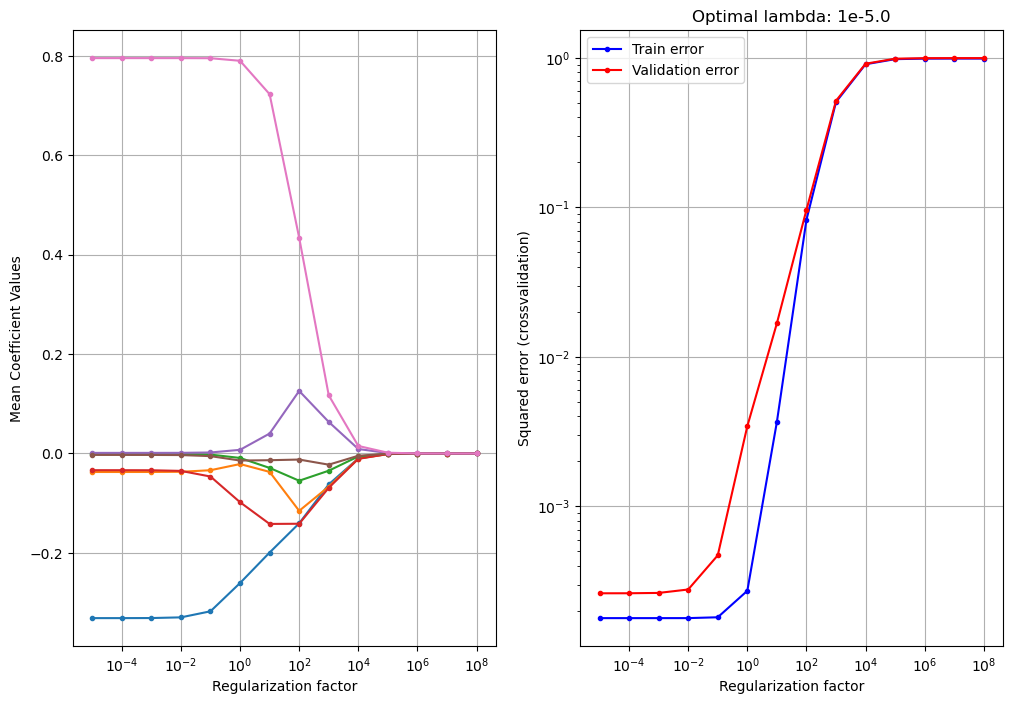

Linear regression without feature selection:
- Training error: 0.00018768630015298903
- Test error:     0.000261814737385618
- R^2 train:     0.9997183783078456
- R^2 test:     0.9995965747757266

Regularized linear regression:
- Training error: 0.00018768985990250112
- Test error:     0.00027467643785970684
- R^2 train:     0.9997183729664719
- R^2 test:     0.9995767564322288



In [52]:
attributeNames = [
    "area_A",
    "perimeter_P",
    "compactness_C",
    "length_of_kernel",
    "width_of_kernel",
    "asymmetry_coefficient",
    "length_of_kernel_groove",
    "class",
]
N = data.shape[0]
M = data.shape[1]
y = X[:, -1]
classNames = ["Kama", "Rosa", "Canadian"]
C = len(classNames)
attributeNames, N, M, y, y.shape, classNames, C

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, stratify=y)

# Standardize the training and set set based on training set mean and std
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)

X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

K = 10
CV = model_selection.KFold(K, shuffle=True)

# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

# Initialize variables
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        plt.figure(k, figsize=(12, 8))
        plt.subplot(1, 2, 1)
        plt.semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        plt.xlabel("Regularization factor")
        plt.ylabel("Mean Coefficient Values")
        plt.grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        plt.subplot(1, 2, 2)
        plt.title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        plt.loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        plt.xlabel("Regularization factor")
        plt.ylabel("Squared error (crossvalidation)")
        plt.legend(["Train error", "Validation error"])
        plt.grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

plt.show()
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

## Regression

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load dataset
#data = np.loadtxt("seeds_dataset.txt")

# Predict 'Area' (first column), use the rest as features
y = data[:, 0]
X = data[:, 1:7]  # Exclude Area

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to torch tensors once
X_tensor_all = torch.tensor(X, dtype=torch.float32)
y_tensor_all = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

# Two-level cross-validation parameters
K1 = K2 = 10
hidden_units = [1,3,5,7,9,11,13,15,17,19,21]

# ANN model training function
def train_model(X_train, y_train, X_val, y_val, hidden_units, lr=0.01, max_epochs=1000):
    M = X_train.shape[1]

    model = nn.Sequential(
        nn.Linear(M, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, 1)
    )

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        mse = mean_squared_error(y_val.numpy(), y_pred.numpy())
    return model, mse

# Statistical evaluation
def statistically_evaluate(name1, squared_error_1, name2, squared_error_2):
    alpha = 0.05
    z = squared_error_1 - squared_error_2
    CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))
    p = 2*st.t.cdf(-np.abs(np.mean(z))/st.sem(z), df=len(z)-1)
    print(f"Confidence interval of {name1}-{name2}: {CI}")
    print(f"p-value: {p}\n")
    return np.mean(z), CI[0], CI[1], p

# Results container
results = []

outer_cv = KFold(n_splits=K1, shuffle=True, random_state=1)

for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
    print(f"Outer fold {outer_fold + 1}/{K1}")
    X_par, y_par = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    best_ann_err = np.inf
    best_ann_model = None
    best_h = None

    best_ols_model = None

     
    inner_cv = KFold(n_splits=K2, shuffle=True, random_state=outer_fold)

    for h in hidden_units:
        print(f"Testing ann with {h} hidden units")
        ann_errs = []
        for inner_train_idx, val_idx in inner_cv.split(X_par):
            X_train = torch.tensor(X_par[inner_train_idx], dtype=torch.float32)
            y_train = torch.tensor(y_par[inner_train_idx].reshape(-1, 1), dtype=torch.float32)
            X_val = torch.tensor(X_par[val_idx], dtype=torch.float32)
            y_val = torch.tensor(y_par[val_idx].reshape(-1, 1), dtype=torch.float32)
            model, mse = train_model(X_train, y_train, X_val, y_val, hidden_units=h)
            ann_errs.append(mse)
        mean_ann_err = np.mean(ann_errs)
        if mean_ann_err < best_ann_err:
            best_ann_err = mean_ann_err
            best_h = h
            X_par_tensor = torch.tensor(X_par, dtype=torch.float32)
            y_par_tensor = torch.tensor(y_par.reshape(-1, 1), dtype=torch.float32)
            best_ann_model, _ = train_model(X_par_tensor, y_par_tensor, X_par_tensor, y_par_tensor, hidden_units=h)

    best_ols_model = LinearRegression().fit(X_par, y_par)

    y_pred_baseline = np.full_like(y_test, np.mean(y_par))
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    best_ann_model.eval()
    with torch.no_grad():
        y_pred_ann = best_ann_model(X_test_tensor).numpy()

    y_pred_ols = best_ols_model.predict(X_test)

    ann_test_error = mean_squared_error(y_test, y_pred_ann)
    ols_test_error = mean_squared_error(y_test, y_pred_ols)
    baseline_test_error = mean_squared_error(y_test, y_pred_baseline)

    results.append([outer_fold + 1, best_h, ann_test_error, ols_test_error, baseline_test_error])


Outer fold 1/10
Testing ann with 1 hidden units
Testing ann with 3 hidden units
Testing ann with 5 hidden units
Testing ann with 7 hidden units
Testing ann with 9 hidden units
Testing ann with 11 hidden units
Testing ann with 13 hidden units
Testing ann with 15 hidden units
Testing ann with 17 hidden units
Testing ann with 19 hidden units


In [ ]:
# Convert to DataFrame
df_results = pd.DataFrame(results, columns=[
    "Outer fold", "h*", "ann E_test", "ols E_test", "baseline E_test"
])

# Save results
df_results.to_csv("regression_two_level_cv_results.csv", index=False)
print("\nFinal cross-validation results:")
#print(df_results)

# Print table
#print("\nResults:")
#header_format = "{:<15}{:<30}{:<30}{:<15}"
#header2_format = "{:<15}" * 5
#row_format = "{:<15}{:<15}{:<15.4g}{:<15.4g}{:<15.4g}"
#print(header_format.format("Outer fold", "ANN", "OLS", "Baseline"))
#print(header2_format.format("i", "h*i", "Etesti", "Etesti", "Etesti"))
#for tup in df_results.itertuples(index=False):
#    print(row_format.format(tup[0], tup[1], tup[2], tup[3], tup[4]))
#print()

df_results



In [ ]:

# Perform statistical comparisons
comparisons = [
    ("ann", df_results["ann E_test"].values, "ols", df_results["ols E_test"].values),
    ("ann", df_results["ann E_test"].values, "baseline", df_results["baseline E_test"].values),
    ("ols", df_results["ols E_test"].values, "baseline", df_results["baseline E_test"].values)
]

print("\nStatistical evaluation results:")
for name1, err1, name2, err2 in comparisons:
    statistically_evaluate(name1, err1, name2, err2)

In [ ]:
# Statistical evaluation as DataFrame
comparisons = [
    ("ANN vs OLS", df_results["ann E_test"].values, df_results["ols E_test"].values),
    ("ANN vs Baseline", df_results["ann E_test"].values, df_results["baseline E_test"].values),
    ("OLS vs Baseline", df_results["ols E_test"].values, df_results["baseline E_test"].values)
]

stat_data = []
for name, x, y in comparisons:
    z = x - y
    ci = st.t.interval(0.95, len(z)-1, loc=np.mean(z), scale=st.sem(z))
    p = 2 * st.t.cdf(-np.abs(np.mean(z)) / st.sem(z), df=len(z)-1)
    stat_data.append([name, np.mean(z), ci[0], ci[1], p])

df_stat_eval = pd.DataFrame(stat_data, columns=[
    "Comparison", "Mean Difference", "95% CI Lower", "95% CI Upper", "p-value"
])

print("\nStatistical Evaluation Results:")
print(df_stat_eval)
